In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import functools
import seaborn as sn
from tqdm import tqdm
from sklearn import preprocessing
from scipy.stats import entropy
from numpy import logical_and as land, logical_or as lor
from utilities import to_float, plot_boxplot, plot_hist

In [2]:
DATA_PATH = 'G:/Shared drives/DM_tweets/data/'

In [3]:
DATA_PATH = 'G:/Drive condivisi/DM_tweets/data/'

In [4]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_no_dupl_1.5.csv', sep='#')
df_users = pd.read_csv(DATA_PATH+'users_clean.csv', sep='#')

# Tweets csv cleaning

## id
In the id column there are only two missing values. Since the column is not meaningful for the analysis phase, the column is dropped.

In [5]:
df_tweets.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10187873 entries, 0 to 10187872
Data columns (total 13 columns):
 #   Column           Non-Null Count     Dtype  
---  ------           --------------     -----  
 0   level_0          10187873 non-null  int64  
 1   id               10187871 non-null  object 
 2   user_id          10112887 non-null  object 
 3   created_at       10187873 non-null  object 
 4   text             9894377 non-null   object 
 5   retweet_count    10187873 non-null  float64
 6   reply_count      10187873 non-null  float64
 7   favorite_count   10187873 non-null  float64
 8   num_hashtags     10187873 non-null  float64
 9   num_urls         10187873 non-null  float64
 10  num_mentions     10187873 non-null  float64
 11  user_id_conv     10187873 non-null  float64
 12  created_at_conv  10187873 non-null  int64  
dtypes: float64(7), int64(2), object(4)
memory usage: 1010.5+ MB


In [6]:
df_tweets.drop(columns=['id'], inplace=True)

## user_id
In the user_id column there are a lot of missing values, wrong values (non-numerical ids) and 129040 user ids do not have any correspondence with users file. Nevertheless, these records have been kept because the other columns could be useful for future analyses.

Select records which have both user_id and text values which are null

In [7]:
df_tweets[np.logical_and(df_tweets['user_id'].isnull(), df_tweets['text'].isnull())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   level_0          0 non-null      int64  
 1   user_id          0 non-null      object 
 2   created_at       0 non-null      object 
 3   text             0 non-null      object 
 4   retweet_count    0 non-null      float64
 5   reply_count      0 non-null      float64
 6   favorite_count   0 non-null      float64
 7   num_hashtags     0 non-null      float64
 8   num_urls         0 non-null      float64
 9   num_mentions     0 non-null      float64
 10  user_id_conv     0 non-null      float64
 11  created_at_conv  0 non-null      int64  
dtypes: float64(7), int64(2), object(3)
memory usage: 0.0+ bytes


Merge users table with tweets table by user_id

In [8]:
df_users.id = df_users.id.astype(str)
merged = df_tweets.merge(df_users, left_on='user_id', right_on='id', how='left')

In [9]:
df_tweets.shape

(10187873, 12)

In [10]:
merged.shape

(10187873, 19)

Number of `user_id` that have no correspondance in users file.

In [11]:
len(merged[merged['id'].isnull()].user_id.unique())

129040

## File checkpoint

In [12]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_no_ids.csv', sep='#', index=False)
df_users.to_csv(path_or_buf=DATA_PATH+'users_no_ids.csv', sep='#', index=False)

In [13]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_no_ids.csv', sep='#')
df_users = pd.read_csv(DATA_PATH+'users_no_ids.csv', sep='#')

# Convert to float
Cast column values to float (there are number to big for int) and set to -1.0 when there is a value which is not a number or an uncastable value (e.g. string)

In [14]:
df_tweets['retweet_count_conv'] = df_tweets.retweet_count.apply(to_float)

In [15]:
df_tweets['reply_count_conv'] = df_tweets.reply_count.apply(to_float)

In [16]:
df_tweets['favorite_count_conv'] = df_tweets.favorite_count.apply(to_float)

In [17]:
df_tweets['num_hashtags_conv'] = df_tweets.num_hashtags.apply(to_float)

In [18]:
df_tweets['num_urls_conv'] = df_tweets.num_urls.apply(to_float)

In [19]:
df_tweets['num_mentions_conv'] = df_tweets.num_mentions.apply(to_float)

In [20]:
df_tweets['created_at_conv'] = pd.to_datetime(df_tweets['created_at']).astype(np.int64)

## File checkpoint

In [21]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_to_float.csv', sep='#', index=False)
df_users.to_csv(path_or_buf=DATA_PATH+'users_to_float.csv', sep='#', index=False)

In [22]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_to_float.csv', sep='#')
df_users = pd.read_csv(DATA_PATH+'users_to_float.csv', sep='#')

# Utilities

In [23]:
def show_statistics(df, col, log=False, norm=False):
    #Extract statistical indicators from the indicated column
    mean = np.mean(df[col].values)
    median = np.median(df[col].values)

    if norm:
        norm_col = preprocessing.MinMaxScaler().fit_transform(np.array(df[col].values).reshape(1, -1).T)
        entr = entropy(norm_col)[0]
    else:
        entr = entropy(df[col])

    print("mean: " + str(mean))
    print("median: " + str(median))
    print("entropy: " + str(entr))
    plot_boxplot(df,col, log)

In [24]:
def fix_values(df, col, replace_condition=None, replace_value=None):
    #Substitute all the -1.0 values (missing values) with the median
    if replace_condition is None:
        median = np.median(df[col].values)
        df[col] = df[col].replace({-1.0: median})
    else:
        if replace_value is None:
            replace_value = df[~replace_condition][col].median()
        df.loc[replace_condition, col] = replace_value

    return df

In [25]:
def check_var_attribute(df, attribute_name):

    df = df[land(land(df[attribute_name].isnull() != True, df[attribute_name] != np.inf), df[attribute_name] != -1)]
    df = df[['user_id', attribute_name]]
    df = df.groupby(by=['user_id']).agg(["mean", "median", "var"])[attribute_name]

    return df

In [ ]:
def replace_with_user_median(df_to_replace, attribute_name, threshold=1e7, replace_tweets_condition=None):

    if replace_tweets_condition is None:
        #Get all the rows to edit
        replace_tweets_condition = df_to_replace[attribute_name] == -1 | df_to_replace[attribute_name] > threshold

    condition_users = df_to_replace.user_id.isin(df_to_replace[replace_tweets_condition].user_id)

    keep_condition = ~replace_tweets_condition

    # Median for that users that have not a correspondance in the user file
    glob_median = df_to_replace[keep_condition][attribute_name].median()

    df_users.id = df_users.id.astype(str)
    df_to_replace.user_id = df_tweets.user_id.astype(str)
    df_merge = df_to_replace.merge(df_users, left_on='user_id', right_on='id', how='left')

    # Median for bot users
    bot_median = df_merge[keep_condition & df_merge['bot'] == 0][attribute_name].median()

    # Median for non bot users
    non_bot_median = df_merge[keep_condition & df_merge['bot'] == 1][attribute_name].median()

    # All the tweets that can be used for median computation of the selected users
    condition_for_median = keep_condition & condition_users

    # For each user of the previous list it extract median and var for the indicated attribute
    df_stats = df_to_replace[condition_for_median].groupby(by=['user_id']).agg(["median", "var"])[attribute_name]

    # Add these values to the original DataFrame
    df_to_replace = df_to_replace.merge(df_stats, left_on='user_id', right_on='user_id', how='left')

    #Get all the users that have just one tweet and so we use median to substitute the indicated column basing on the user type
    condition_one_tweet = df_to_replace['var'].isnull() == True & condition_users

    condition_one_tweet_non_bot = df_merge.bot == 0 & condition_one_tweet
    condition_one_tweet_bot = df_merge.bot == 1 & condition_one_tweet
    condition_one_tweet_others = df_merge.bot.isnull() & condition_one_tweet

    df_to_replace.loc[condition_one_tweet_non_bot, attribute_name] = non_bot_median
    df_to_replace.loc[condition_one_tweet_bot, attribute_name] = bot_median
    df_to_replace.loc[condition_one_tweet_others, attribute_name] = glob_median

    # Substitute wrong values with the median of the user that has more than one tweet
    condition_more_tweet = df_to_replace[attribute_name] != glob_median & df_to_replace[attribute_name] != non_bot_median & df_to_replace[attribute_name] != bot_median & condition_users
    df_to_replace.loc[condition_more_tweet, attribute_name] = df_to_replace[condition_more_tweet]['median']

    df_to_replace.drop(columns=['median','var'], inplace=True)

    return df_to_replace

In [ ]:
def check_bot_stats_diff(col):

    df_users.id = df_users.id.astype(str)
    df_tweets.user_id = df_tweets.user_id.astype(str)
    df_merge = df_tweets.merge(df_users, left_on='user_id', right_on='id', how='right')

    df_merge_clean = df_merge[(df_merge[col] != -1) & (df_merge[col] < np.inf)]

    median_bot = df_merge_clean[df_merge_clean['bot'] == 1][col].median()
    mean_bot = df_merge_clean[df_merge_clean['bot'] == 1][col].mean()
    entropy_bot = entropy(df_merge_clean[df_merge['bot'] == 1][col])

    median_non_bot = df_merge_clean[df_merge_clean['bot'] == 0][col].median()
    mean_non_bot = df_merge_clean[df_merge_clean['bot'] == 0][col].mean()
    entropy_non_bot = entropy(df_merge_clean[df_merge_clean['bot'] == 0][col])

    median_all = df_merge_clean[col].median()
    mean_all = df_merge_clean[col].mean()
    entropy_all = entropy(df_merge_clean[col])

    print(col + ":")
    print("\tmedian bot: " + str(median_bot) + " median non bot: " + str(median_non_bot) + " median all: " + str(median_all))
    print("\tmean bot: " + str(mean_bot) + " mean non bot: " + str(median_non_bot) + " mean all: " + str(mean_all))
    print("\tentropy bot: " + str(entropy_bot) + " entropy non bot: " + str(median_non_bot) + " entropy all: " + str(entropy_all))

# Preliminary checks

In [28]:
attrs = ["retweet_count", "reply_count", "favorite_count", "num_mentions", "num_urls", "num_hashtags"]
for attr in attrs:
    check_bot_stats_diff(attr)
    print("----------------------------------------------")

retweet_count:
	median bot: 0.0 median non bot: 0.0 median all: 0.0
	mean bot: 1.1338421260900474e+128 mean non bot: 0.0 mean all: 3.951900627087591e+127
	entropy bot: 0.6931471805599453 entropy non bot: 0.0 entropy all: 0.6931471805599453
----------------------------------------------
reply_count:
	median bot: 0.0 median non bot: 0.0 median all: 0.0
	mean bot: 5.713262224167528e+103 mean non bot: 0.0 mean all: 1.9950443099342137e+103
	entropy bot: 1.4280201805310366e-12 entropy non bot: 0.0 entropy all: 1.428020180549496e-12
----------------------------------------------
favorite_count:
	median bot: 0.0 median non bot: 0.0 median all: 0.0
	mean bot: 4.3102213780758885e+93 mean non bot: 0.0 mean all: 6.918901480081521e+204
	entropy bot: 0.6931471805713403 entropy non bot: 0.0 entropy all: 5.59810120460225e-110
----------------------------------------------
num_mentions:
	median bot: 0.0 median non bot: 1.0 median all: 0.0
	mean bot: 1.7268651870885742e+81 mean non bot: 1.0 mean all: 6.

# Clean retweet_counts column

C:\Users\Alessandro\lib\site-packages\scipy\stats\_entropy.py:77: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


mean: inf
median: 0.0
entropy: nan


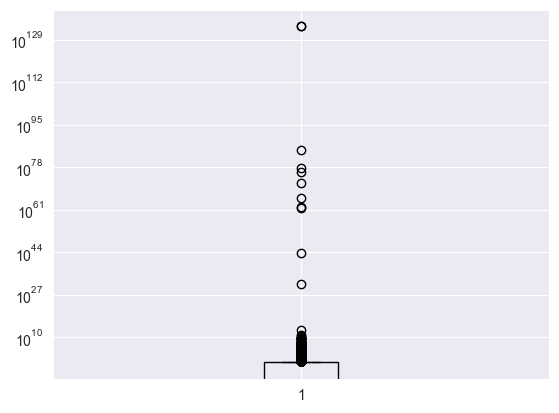

In [29]:
show_statistics(df_tweets,'retweet_count_conv', log=True)

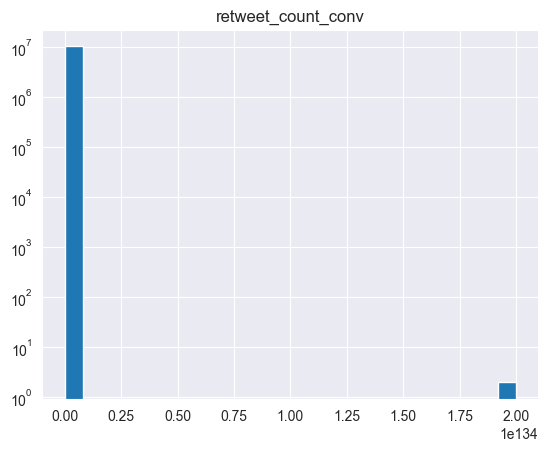

In [30]:
plot_hist(df_tweets[df_tweets['retweet_count_conv']!=np.inf], 'retweet_count_conv')

As it is possible to see the distribution is positively skewed. Considering the statistical indicators, it is clear that the mean is too much influenced by outliers so the median has been taken in account.
The search for the optimal threshold is performed by looking at the boxplot and decreasing the threshold until a dense tail is finally visible.

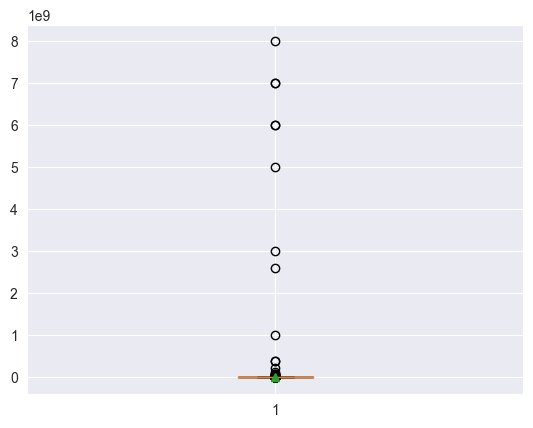

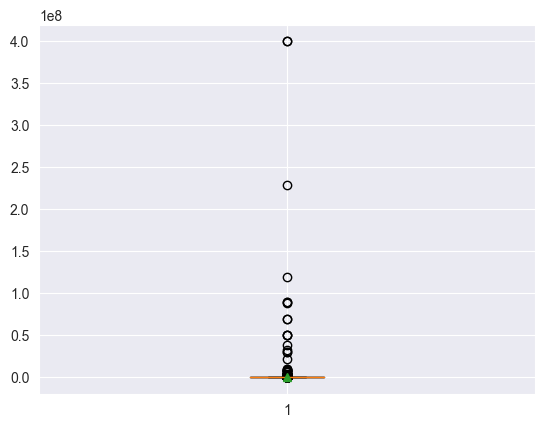

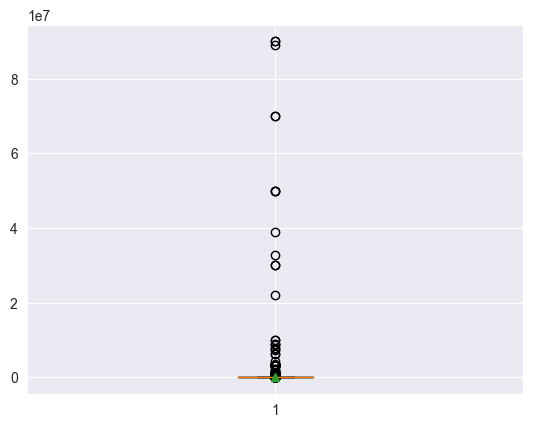

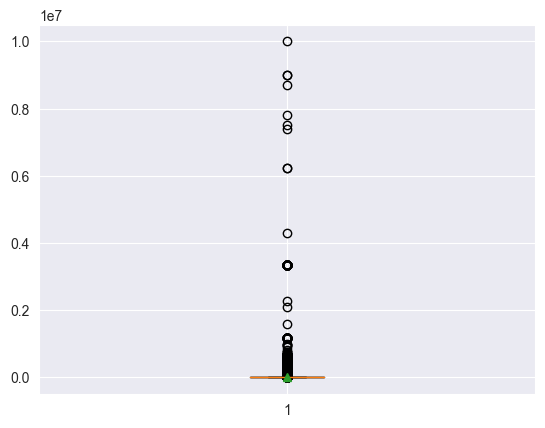

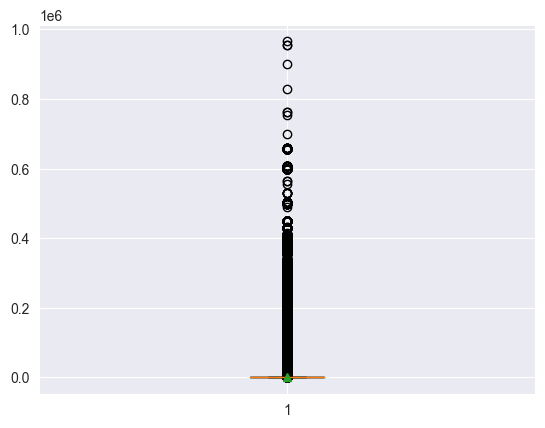

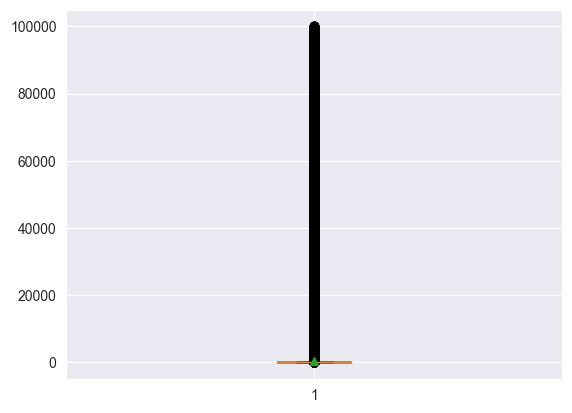

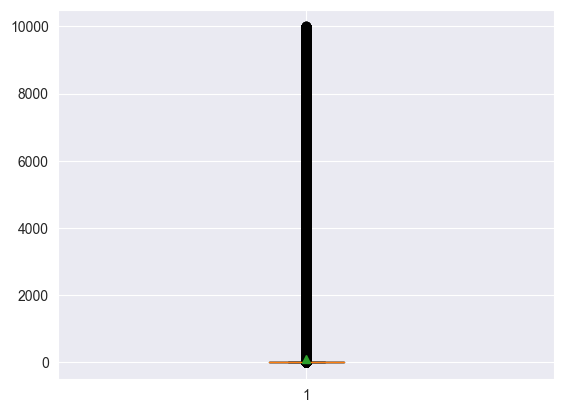

In [31]:
for p in range(10,3,-1):
    threshold = 10**p
    plot_boxplot(df_tweets[df_tweets.retweet_count_conv.values < threshold],'retweet_count_conv', log=False)

5 * 1e5 seems to be a reasonable threshold.
For the missing values (-1) and the values over the threshold (1e7) we have checked if the same user has other tweets in the dataset to extract statistics from them. If there are not other tweets or there are only tweets with missing values the median is set as default.

In [32]:
threshold = 5e5
df_tweets = replace_with_user_median(df_tweets, 'retweet_count_conv', threshold=threshold)

TypeError: Cannot perform 'ror_' with a dtyped [float64] array and scalar of type [bool]

In [ ]:
show_statistics(df_tweets,'retweet_count_conv')

In [ ]:
plot_hist(df_tweets, 'retweet_count_conv')

In [ ]:
df_tweets.drop(columns = ['retweet_count'], inplace=True)

Same procedure has been applied to `reply_count` and `favorite_count` columns with different thresholds (respectively 1e5 and 1e6).

# Clean reply_count column

In [ ]:
show_statistics(df_tweets,'reply_count_conv', log=True)

In [ ]:
plot_hist(df_tweets[df_tweets['reply_count_conv']!=np.inf], 'reply_count_conv')

In [ ]:
for p in range(10,3,-1):
    threshold = 10**p
    plot_boxplot(df_tweets[df_tweets.reply_count_conv.values < threshold],'reply_count_conv', log=False)

Cutting at 2 millions  or 600000 seems to be a reasonable choidce

In [ ]:
threshold =2e6
df_tweets = replace_with_user_median(df_tweets, 'reply_count_conv', threshold=threshold)

In [ ]:
show_statistics(df_tweets,'reply_count_conv', True)

In [ ]:
plot_hist(df_tweets, 'reply_count_conv')

In [ ]:
df_tweets.drop(columns = ['reply_count'], inplace=True)

# Clean favorite_count column

In [ ]:
show_statistics(df_tweets,'favorite_count_conv', log=True)

In [ ]:
plot_hist(df_tweets[df_tweets['favorite_count_conv']!=np.inf], 'favorite_count_conv')

In [ ]:
for p in range(10,3,-1):
    threshold = 10**p
    plot_boxplot(df_tweets[df_tweets.favorite_count_conv.values < threshold],'favorite_count_conv', log=False)

5e5 seems a reasonable point to cut

In [ ]:
threshold = 5e5
df_tweets = replace_with_user_median(df_tweets, 'favorite_count_conv', threshold=threshold)

In [ ]:
show_statistics(df_tweets,'favorite_count_conv', True)

In [ ]:
plot_hist(df_tweets, 'favorite_count_conv')

In [ ]:
df_tweets.drop(columns = ['favorite_count'], inplace=True)

# File checkpoint

In [ ]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_clean_counts.csv', sep='#', index=False)

In [ ]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_clean_counts.csv', sep='#')

# Created at

In [ ]:
show_statistics(df_tweets,'created_at_conv', log=False, norm=True)

In [ ]:
twitter_foundation = pd.to_datetime(["20060321"]).astype(np.int64)[0]
sep_2022 = pd.to_datetime(["20220915"]).astype(np.int64)[0]
twitter_foundation

In [ ]:
replace_condition= lor(df_tweets.created_at_conv < twitter_foundation, df_tweets.created_at_conv > sep_2022)
df_tweets = replace_with_user_median(df_tweets, 'created_at_conv', replace_condition=replace_condition )

In [ ]:
df_tweets['created_at'] = pd.to_datetime(df_tweets.created_at_conv)

Check that user tweets have created_at set after its subscription to twitter

In [ ]:
df_users.id = df_users.id.astype(str)
df_merged = df_tweets.merge(df_users, left_on='user_id', right_on='id', how='left')
df_merged.info()

In [ ]:
df_merged[df_merged.created_at_conv_x < df_merged.created_at_conv_y]

In [ ]:
df_tweets[df_tweets.created_at_conv == df_tweets.created_at_conv.max()]

In [ ]:
df_tweets[df_tweets.created_at_conv == df_tweets.created_at_conv.min()]

In [ ]:
show_statistics(df_tweets, 'created_at_conv', log=False, norm=True)

# File checkpoint

In [ ]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_clean_created_at.csv', sep='#', index=False)

In [ ]:
df_tweets = pd.read_csv(DATA_PATH+'tweets_clean_created_at.csv', sep='#')

# Number of hashtags

An hashtag is composed by at least 2 characters, the `#` and an alphanumeric symbol. Since the 8th of november 2017 a tweet is made by at most 280 characters, before 2017, the maximum was 140. So the maximum number of hashtags in a tweet before 2017-11-8 should be 70, after 2017-11-8 140.

In [ ]:
show_statistics(df_tweets, 'num_hashtags_conv', log=True)

In [ ]:
plot_hist(df_tweets[df_tweets.num_hashtags_conv != np.inf], 'num_hashtags_conv')

In [ ]:
double_char_date = pd.to_datetime(["20171108"]).astype(np.int64)[0]

In [ ]:
max_hash_num = 140/3

# Conditions
date_cond = df_tweets.created_at_conv < double_char_date
max_cond = df_tweets.num_hashtags_conv > max_hash_num
wrong_cond = df_tweets.num_hashtags_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_hashtags_conv.median()

df_tweets = fix_values(df_tweets, 'num_hashtags_conv', replace_cond, replace_value)

In [ ]:
max_hash_num = 280/3

# Conditions
date_cond = df_tweets.created_at_conv > double_char_date
max_cond = df_tweets.num_hashtags_conv > max_hash_num
wrong_cond = df_tweets.num_hashtags_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_hashtags_conv.median()

df_tweets = fix_values(df_tweets, 'num_hashtags_conv', replace_cond, replace_value)

In [ ]:
show_statistics(df_tweets, 'num_hashtags_conv')

In [ ]:
df_tweets[df_tweets.num_hashtags_conv == df_tweets.num_hashtags_conv.max()]

In [ ]:
df_tweets.drop(columns = ['num_hashtags'], inplace=True)

# Number of mentions

A mention is composed by at least 2 characters, the `@` and an alphanumeric symbol. Since the 8th of november 2017 a tweet is made by at most 280 characters, before 2017, the maximum was 140. So the maximum number of mention in a tweet before 2017-11-8 should be 70, after 2017-11-8 140.

In [ ]:
show_statistics(df_tweets, 'num_mentions_conv', log=True)

In [ ]:
plot_hist(df_tweets[df_tweets.num_mentions_conv != np.inf], 'num_mentions_conv')

In [ ]:
double_char_date = pd.to_datetime(["20171108"]).astype(np.int64)[0]

In [ ]:
max_mentions_num = 140/3

# Conditions
date_cond = df_tweets.created_at_conv < double_char_date
max_cond = df_tweets.num_mentions_conv > max_mentions_num
wrong_cond = df_tweets.num_mentions_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_mentions_conv.median()

df_tweets = fix_values(df_tweets, 'num_mentions_conv', replace_cond, replace_value)

In [ ]:
max_mentions_num = 280/3

# Conditions
date_cond = df_tweets.created_at_conv > double_char_date
max_cond = df_tweets.num_mentions_conv > max_mentions_num
wrong_cond = df_tweets.num_mentions_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_mentions_conv.median()

df_tweets = fix_values(df_tweets, 'num_mentions_conv', replace_cond, replace_value)

In [ ]:
show_statistics(df_tweets, 'num_mentions_conv')

In [ ]:
df_tweets[df_tweets.num_mentions_conv == df_tweets.num_mentions_conv.max()]

In [ ]:
df_tweets.drop(columns = ['num_mentions'], inplace=True)

# Num URLS

A URL is composed by at least 3 characters, like `a.co`. Since the 8th of november 2017 a tweet is made by at most 280 characters, before 2017, the maximum was 140. So the maximum number of urls in a tweet before 2017-11-8 should be 35, after 2017-11-8 70.

In [ ]:
show_statistics(df_tweets, 'num_urls_conv', log=True)

In [ ]:
plot_hist(df_tweets[df_tweets.num_urls_conv != np.inf], 'num_urls_conv')

In [ ]:
double_char_date = pd.to_datetime(["20171108"]).astype(np.int64)[0]

In [ ]:
max_url_num = 140/5

# Conditions
date_cond = df_tweets.created_at_conv < double_char_date
max_cond = df_tweets.num_urls_conv > max_url_num
wrong_cond = df_tweets.num_urls_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_urls_conv.median()

df_tweets = fix_values(df_tweets, 'num_urls_conv', replace_cond, replace_value)

In [ ]:
max_url_num = 280/5

# Conditions
date_cond = df_tweets.created_at_conv > double_char_date
max_cond = df_tweets.num_urls_conv > max_url_num
wrong_cond = df_tweets.num_urls_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_urls_conv.median()

df_tweets = fix_values(df_tweets, 'num_urls_conv', replace_cond, replace_value)

In [ ]:
show_statistics(df_tweets, 'num_urls_conv')

In [ ]:
df_tweets[df_tweets.num_urls_conv == df_tweets.num_urls_conv.max()]

In [ ]:
df_tweets.drop(columns = ['num_urls'], inplace=True)

In [ ]:
df_tweets.rename(columns={"retweet_count_conv": "retweet_count", "reply_count_conv": "reply_count", "favorite_count_conv": "favorite_count",
                          "num_hashtags_conv": "num_hashtags", "num_urls_conv": "num_urls", "num_mentions_conv": "num_mentions"}, inplace = True)

In [ ]:
df_tweets = df_tweets.astype({"retweet_count": 'int32', "reply_count": 'int32', "favorite_count" : 'int32',
                          "num_hashtags": 'int32', "num_urls": 'int32', "num_mentions": 'int32'})

In [ ]:
df_tweets.drop(columns=['level_0', 'user_id_conv'], inplace=True)

In [ ]:
df_tweets.to_csv(path_or_buf=DATA_PATH+'tweets_clean.csv', sep='#', index=False)